<a href="https://colab.research.google.com/github/JUPUDI-VAMSI-KALYAN/Coursera_Capstone/blob/master/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Capstone Project : Battle of Neighborhood Dublin(week2)
Analyse Dublin data for business problem - IBM/Data Science Coursera
Introduction: Business Problem
Idea of this project is - If a business person want to open a restaurant or a grocery shop in Dublin, help him/her analyse which area would be better depending on competition and population within Dublin.

Background
In recent years Migrations to Ireland are increased and most of the migrant are based at Dublin location. Due to increased housing prices in Dublin city area, people are preferring to locate little away from Dublin, but they find difficult to locate good restaurants or grocery store near their homes. In such scenario, restaurants like Asian, Chinese or Italian cuisine or even a grocery restaurant would be blessing for people and they won’t need to visit Dublin city centre always.

Data
For the problem mentioned we would need data

Location data for Dublin postal districts and greater dublin
Venues data around all Dublin postal districts and for Greater Dublin regions
Also population data for 4 major regions of Dublin

In [34]:
pip install geocoder

In [35]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge geocoder --yes
import geocoder # import geocoder

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!conda install -c conda-forge folium=0.5.0 --yes

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

print('All libraries Downloaded!')

/bin/bash: conda: command not found
/bin/bash: conda: command not found
/bin/bash: conda: command not found
All libraries Downloaded!


In [0]:

#Scrap data from URL for Dublin region population data
#url= 'https://en.wikipedia.org/wiki/List_of_Irish_counties_by_population'
url = 'https://en.wikipedia.org/wiki/County_Dublin'
response = requests.get(url)
html = response.text
df_gdublin = pd.read_html(html)
df_gdublin= df_gdublin[1]
df_gdublin=df_gdublin.drop(columns=['Name','Area']).reset_index(drop=True)
df_gdublin.rename(columns={'Name.1':'Neighborhood','Population[6]':'Population'}, inplace=True)

In [37]:
df_gdublin.head()

,Neighborhood,Population
0,Dublin City,553165
1,Dún Laoghaire–Rathdown,217274
2,Fingal,296214
3,South Dublin,278749


In [38]:
#Get locations of 4 major areas of Dublin
dublin_areas=[]
latitudes=[]
longitudes=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for area in df_gdublin['Neighborhood']:
    print(area)
    location = geolocator.geocode(area,timeout=20)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)
    
df_gdublin['Latitude'] = latitudes
df_gdublin['Longitude'] = longitudes
df_gdublin

Dublin City
Dún Laoghaire–Rathdown
Fingal
South Dublin


,Neighborhood,Population,Latitude,Longitude
0,Dublin City,553165,53.349764,-6.260273
1,Dún Laoghaire–Rathdown,217274,53.256721,-6.204865
2,Fingal,296214,53.494221,-6.224980
3,South Dublin,278749,53.273260,-6.407077


In [39]:

#get postal district locations
latitudes=[]
longitudes=[]
districts=[]
geolocator = Nominatim(user_agent="On_explorer")
#extract greater Dublin areas 
for n in range(1, 25):
    area = 'Dublin {}'.format(n)
    districts.append(area)
    #print(area)
    location = geolocator.geocode(area, timeout=50)
    latitudes.append(location.latitude)
    longitudes.append(location.longitude)

df_dublin = pd.DataFrame({'Neighborhood':districts, 'Latitude':latitudes, 'Longitude':longitudes})
df_dublin.head()

,Neighborhood,Latitude,Longitude
0,Dublin 1,53.352488,-6.256646
1,Dublin 2,53.338940,-6.252713
2,Dublin 3,53.361223,-6.185467
3,Dublin 4,53.327507,-6.227486
4,Dublin 5,53.383454,-6.181923


In [40]:

address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="On_explorer")
location = geolocator.geocode(address)
latitude_dublin = location.latitude
longitude_dublin = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(latitude_dublin, longitude_dublin))

The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


In [0]:
CLIENT_ID = 'TK02EUO5TJCWNM0OBBLZUNQGF4UAFQSAJCTAW5FEPZCKAVUW' # your Foursquare ID
CLIENT_SECRET = 'XKZAFTTF5V4LH02122JSISTXVUKB32QMNUES4LEEWJYKA5MI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [0]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
       
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [43]:
gdublin_venues= getNearbyVenues(df_gdublin['Neighborhood'],df_gdublin['Latitude'],df_gdublin['Longitude'],radius=8000)
print(gdublin_venues.shape)
gdublin_venues.head()

(398, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant


In [44]:

#check if duplicate venues are in data , check venue Latitude, Longitude - not same
indextodrop= gdublin_venues[gdublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
print(indextodrop)
gdublin_venues.drop(index = indextodrop, inplace=True)
gdublin_venues.shape

Int64Index([285, 315, 325], dtype='int64')


(395, 7)

In [45]:
dublin_venues= getNearbyVenues(df_dublin['Neighborhood'],df_dublin['Latitude'],df_dublin['Longitude'])
print(dublin_venues.shape)
dublin_venues.head()

(1686, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega
1,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater
2,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel
3,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub
4,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant


In [46]:

#check if duplicate venues are in data , check venue Latitude, Longitude - not same
indextodrop= dublin_venues[dublin_venues[['Venue Latitude','Venue Longitude']].duplicated() == True].index
print(indextodrop)
dublin_venues.drop(index = indextodrop, inplace=True)
dublin_venues.shape

Int64Index([ 107,  109,  110,  112,  115,  117,  119,  121,  122,  123,
            ...
            1622, 1624, 1626, 1627, 1628, 1637, 1647, 1648, 1649, 1651],
           dtype='int64', length=556)


(1130, 7)

In [47]:

#Print Unique categoeries
print("Unique category of Dublin districts venues: ", dublin_venues['Venue Category'].nunique())
print("Unique category of Greater Dublin venues: ", len(gdublin_venues['Venue Category'].unique()))

Unique category of Dublin districts venues:  189
Unique category of Greater Dublin venues:  113


In [48]:

print(dublin_venues.shape)
dublin_venues['Restaurant']=(dublin_venues['Venue Category'].str.contains('Restaurant')).astype(int)
dublin_venues['Italian Restaurant']=(dublin_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
dublin_venues['Cafe']=(dublin_venues['Venue Category'].str.contains('Coffee Shop') | dublin_venues['Venue Category'].str.contains('Café')).astype(int)
#dublin_venues['Pub']=(dublin_venues['Venue Category'].str.contains('Pub')).astype(int)
dublin_venues['Asian']=(dublin_venues['Venue Category'].str.contains('Asian')).astype(int)
dublin_venues['Grocery Store']=(dublin_venues['Venue Category'].str.contains('Grocery Store')).astype(int)
dublin_venues.head()

(1130, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin 1,53.352488,-6.256646,147 Deli,53.353410,-6.259807,Deli / Bodega,0,0,0,0,0
1,Dublin 1,53.352488,-6.256646,Gate Theatre,53.353113,-6.261997,Theater,0,0,0,0,0
2,Dublin 1,53.352488,-6.256646,Holiday Inn Express Dublin City Centre Hotel,53.352306,-6.260955,Hotel,0,0,0,0,0
3,Dublin 1,53.352488,-6.256646,The Celt,53.350442,-6.255071,Pub,0,0,0,0,0
4,Dublin 1,53.352488,-6.256646,The Hop House (Kim Chi),53.352981,-6.260772,Korean Restaurant,1,0,0,0,0


In [49]:
print(gdublin_venues.shape)
gdublin_venues['Restaurant']=(gdublin_venues['Venue Category'].str.contains('Restaurant')).astype(int)
gdublin_venues['Italian Restaurant']=(gdublin_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
gdublin_venues['Cafe']=(gdublin_venues['Venue Category'].str.contains('Coffee Shop') | gdublin_venues['Venue Category'].str.contains('Café')).astype(int)
#gdublin_venues['Pub']=(gdublin_venues['Venue Category'].str.contains('Pub')).astype(int)
gdublin_venues['Asian']=(gdublin_venues['Venue Category'].str.contains('Asian')).astype(int)
gdublin_venues['Grocery Store']=(gdublin_venues['Venue Category'].str.contains('Grocery Store')).astype(int)
gdublin_venues.head()

(395, 7)


,Neighborhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin City,53.349764,-6.260273,147 Deli,53.353410,-6.259807,Deli / Bodega,0,0,0,0,0
1,Dublin City,53.349764,-6.260273,Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop,0,0,1,0,0
2,Dublin City,53.349764,-6.260273,Pull&Bear,53.349533,-6.262053,Clothing Store,0,0,0,0,0
3,Dublin City,53.349764,-6.260273,Vintage Cocktail Club,53.345127,-6.262851,Cocktail Bar,0,0,0,0,0
4,Dublin City,53.349764,-6.260273,The Winding Stair,53.346596,-6.263784,Restaurant,1,0,0,0,0


In [50]:
dublin_rest = dublin_venues.groupby('Neighborhood').sum().reset_index()
#dublin_rest = dublin_rest.merge(df_dublin[['Neighborhood'],  left_on='Neighborhood', right_on='Neighborhood')
dublin_rest = dublin_rest.drop(columns=['Venue Latitude','Venue Longitude'])
dublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin 1,5335.248810,-625.664569,16,3,18,0,1
1,Dublin 10,4267.457324,-508.877088,13,1,5,2,3
2,Dublin 11,2936.263748,-346.094481,7,0,5,2,3
3,Dublin 12,1812.897988,-215.180021,5,1,4,1,4
4,Dublin 13,2989.596473,-340.221466,12,1,11,0,0


In [51]:
gdublin_rest = gdublin_venues.groupby('Neighborhood').sum().reset_index()
#dublin_rest = dublin_rest.merge(df_dublin[['Neighborhood'],  left_on='Neighborhood', right_on='Neighborhood')
gdublin_rest = gdublin_rest.drop(columns=['Venue Latitude','Venue Longitude'])
gdublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store
0,Dublin City,5334.976450,-626.027320,12,2,20,0,1
1,Dún Laoghaire–Rathdown,5325.672110,-620.486547,16,3,14,0,2
2,Fingal,5188.939461,-603.823080,18,5,17,0,1
3,South Dublin,5220.779514,-627.893517,18,1,11,1,1


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

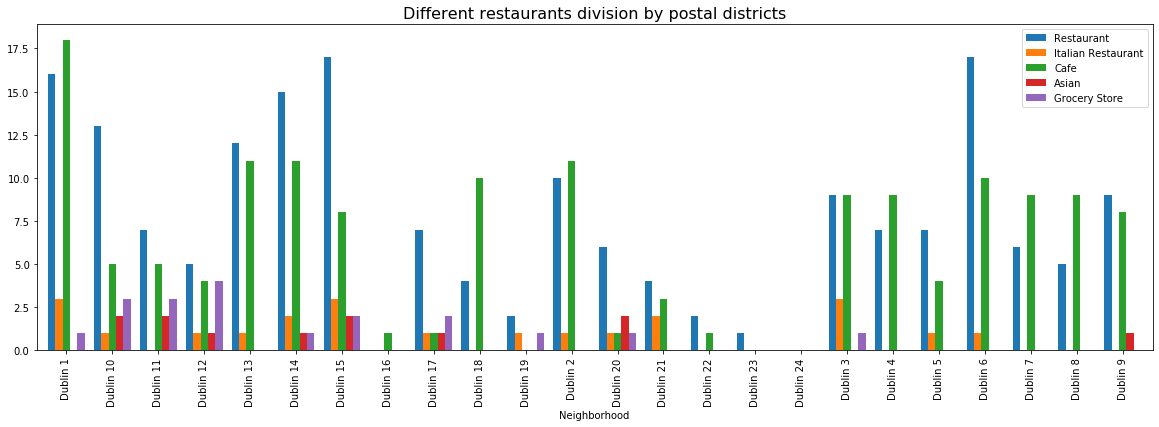

In [53]:

ax1=dublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Asian','Grocery Store'], kind='bar',figsize = (20,6),
                width = 0.8)
ax1.set_title("Different restaurants division by postal districts", 
             fontsize = 16)
plt.show()

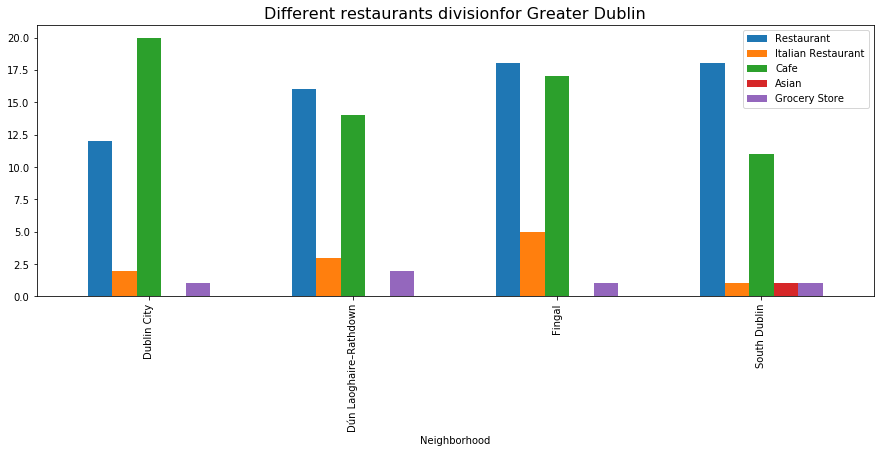

In [54]:

ax1=gdublin_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Asian','Grocery Store'], kind='bar',figsize = (15,5),
                width = 0.6)
ax1.set_title("Different restaurants divisionfor Greater Dublin", 
             fontsize = 16)
plt.show()

In [55]:

totalrest =dublin_rest['Restaurant'].sum()
dublin_rest['rest_percent']=(dublin_rest['Restaurant']/totalrest)*100
totalgrocery = dublin_rest['Grocery Store'].sum()
dublin_rest['grocery_percent']=(dublin_rest['Grocery Store']/totalgrocery)*100
totalrest=dublin_rest['Italian Restaurant'].sum()
dublin_rest['Italianrest_per']=(dublin_rest['Italian Restaurant']/totalrest)*100
totalrest=dublin_rest['Asian'].sum()
dublin_rest['Asian_per']=(dublin_rest['Asian']/totalrest)*100
#calculate % for greater dublin
totalrest_gd=gdublin_rest['Restaurant'].sum()
gdublin_rest['rest_percent']=(gdublin_rest['Restaurant']/totalrest_gd)*100
totalgrocery = gdublin_rest['Grocery Store'].sum()
gdublin_rest['grocery_percent']=(gdublin_rest['Grocery Store']/totalgrocery)*100
totalrest_gd=gdublin_rest['Italian Restaurant'].sum()
gdublin_rest['Italianrest_per']=(gdublin_rest['Italian Restaurant']/totalrest_gd)*100
totalrest_gd=gdublin_rest['Asian'].sum()
gdublin_rest['Asian_per']=(gdublin_rest['Asian']/totalrest_gd)*100
dublin_rest.head()

,Neighborhood,Latitude,Longitude,Restaurant,Italian Restaurant,Cafe,Asian,Grocery Store,rest_percent,grocery_percent,Italianrest_per,Asian_per
0,Dublin 1,5335.248810,-625.664569,16,3,18,0,1,8.839779,5.263158,13.636364,0.000000
1,Dublin 10,4267.457324,-508.877088,13,1,5,2,3,7.182320,15.789474,4.545455,16.666667
2,Dublin 11,2936.263748,-346.094481,7,0,5,2,3,3.867403,15.789474,0.000000,16.666667
3,Dublin 12,1812.897988,-215.180021,5,1,4,1,4,2.762431,21.052632,4.545455,8.333333
4,Dublin 13,2989.596473,-340.221466,12,1,11,0,0,6.629834,0.000000,4.545455,0.000000


In [0]:
totalpopulation= df_gdublin['Population'].sum()
df_gdublin['population_per']=(df_gdublin['Population']/totalpopulation)*100

df_gdublin=df_gdublin.merge(gdublin_rest[['Neighborhood','rest_percent','grocery_percent','Italianrest_per','Asian_per']], on='Neighborhood')

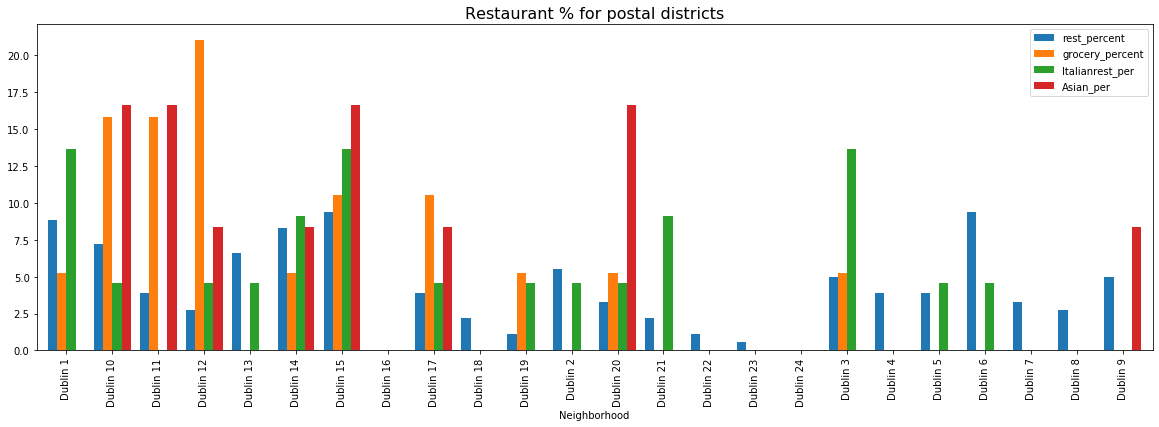

In [57]:
ax1=dublin_rest.plot(x='Neighborhood',y=['rest_percent','grocery_percent','Italianrest_per','Asian_per'], kind='bar',figsize = (20,6),
                width = 0.8)
ax1.set_title("Restaurant % for postal districts", 
             fontsize = 16)
plt.show()

In [58]:

df_gdublin

,Neighborhood,Population,Latitude,Longitude,population_per,rest_percent,grocery_percent,Italianrest_per,Asian_per
0,Dublin City,553165,53.349764,-6.260273,41.115221,18.750,20.0,18.181818,0.0
1,Dún Laoghaire–Rathdown,217274,53.256721,-6.204865,16.149374,25.000,40.0,27.272727,0.0
2,Fingal,296214,53.494221,-6.224980,22.016765,28.125,20.0,45.454545,0.0
3,South Dublin,278749,53.273260,-6.407077,20.718640,28.125,20.0,9.090909,100.0


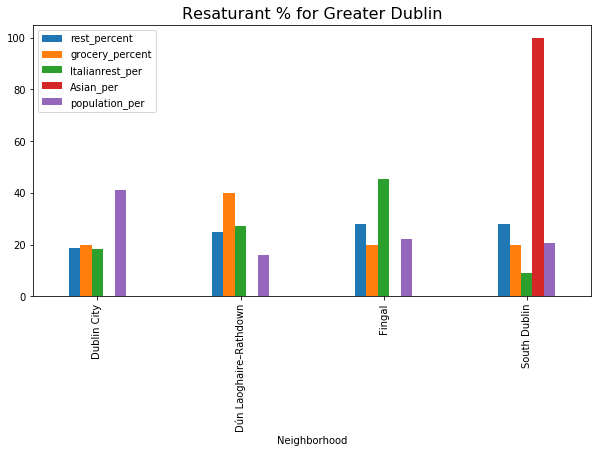

In [59]:
ax1=df_gdublin.plot(x='Neighborhood',y=['rest_percent','grocery_percent','Italianrest_per','Asian_per','population_per'], kind='bar',figsize = (10,5),
                width = 0.4)
ax1.set_title("Resaturant % for Greater Dublin", 
             fontsize = 16)
plt.show()

In [60]:
def get_color(category):
    if 'Asian' in category:
        col = 'red'
    if 'Grocery' in category:
        col = 'orange'
    if 'Italian' in category:
        col = 'green'
    return col

map_dublin = folium.Map(location=[latitude_dublin,longitude_dublin], zoom_start=10)
dublin_plot = dublin_venues[dublin_venues['Venue Category'].str.contains('Asian') | dublin_venues['Venue Category'].str.contains('Grocery') | dublin_venues['Venue Category'].str.contains('Italian')] 
for lat, lon,area, cat in zip(dublin_plot['Venue Latitude'], dublin_plot['Venue Longitude'],dublin_plot['Neighborhood'],dublin_plot['Venue Category']):
    folium.CircleMarker([lat, lon], radius=5, 
                        popup=area,
                        color=get_color(cat), 
                        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dublin)
    
map_dublin

In [61]:

# one hot encoding
dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [62]:

dublin_onehot = pd.get_dummies(dublin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dublin_onehot['Neighborhood'] = dublin_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dublin_onehot.columns[-1]] + list(dublin_onehot.columns[:-1])
dublin_onehot = dublin_onehot[fixed_columns]

dublin_onehot.head(10)

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0

In [63]:

dublin_grouped = dublin_onehot.groupby('Neighborhood').mean().reset_index()
dublin_grouped

,Neighborhood,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Castle,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Library,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,English Restaurant,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hill,Historic Site,History Museum,Hobby Shop,Home Service,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Light Rail Station,Lighthouse,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Outdoor Sculpture,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Port,Portuguese Restaurant,Pub,Racetrack,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Climbing Spot,Rugby Pitch,Salad Place,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Ski Area,Soccer Field,Soccer Stadium,Souvenir Shop,Spa,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Dublin 1,0.000000,0.000000,0.000000,0.000000,0.010000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.000000,0.090000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.090000,0.01,0.010000,0.000000,0.000000,0.01,0.000000,0.010000,0.000000,0.01,0.000000,0.010000,0.01,0.000000,0.00,0.0,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.020000,0.01,0.000000,0.000000,0.000000,0.000000,0.0,0.010000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.030000,0.010000,0.000000,0.030000,0.000000,0.010000,0.0000,0.000000,0.000000,0.030000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.020000,0.000000,0.000000,0.000000,0.140000,0.000000,0.01,0.01,0.00000,0.050000,0.000000,0.000000,0.01,0.000000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.04

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dublin_grouped['Neighborhood']

for ind in np.arange(dublin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dublin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Pub,Coffee Shop,Café,Restaurant,Theater,Ice Cream Shop,Hotel,Italian Restaurant,Beer Bar,Museum
1,Dublin 10,Supermarket,Fast Food Restaurant,Park,Convenience Store,Coffee Shop,Grocery Store,Hotel,Tram Station,Chinese Restaurant,Bistro
2,Dublin 11,Supermarket,Coffee Shop,Diner,Fast Food Restaurant,Grocery Store,Bar,Pub,Asian Restaurant,Sporting Goods Shop,Hotel
3,Dublin 12,Grocery Store,Park,Coffee Shop,Supermarket,Shopping Mall,Pub,Bar,Deli / Bodega,Sports Club,Clothing Store
4,Dublin 13,Seafood Restaurant,Café,Pub,Coffee Shop,Lighthouse,Golf Course,Train Station,Trail,Deli / Bodega,Beach


**Analysis**
Overall Asian Restaurants have less/0 existence in Dublin City (Dublin 1, Dublin 2) , Fingal and Dun-Laghorie areas, region which has plenty of restaurants and cafe otherwise. Assuming Asian migrated peoples are settling in Dublin 15, Dublin 2, Dublin 4 postal districts majorly, hence Dubin2 and Dublin4 can be a good potential area for Asian restaurant

**Conclusion**
Dublin City, Fingal and Dun-Laghorie would be potential regions to open a Asian Restaurant.

Assuming increasing population in Dublin 4, Dublin 8 and Fingal region, Asian restaurants would have good potential in these areas of Dublin